# Telstra Network Disruptions

Telstra is the largest Telecom Service Provider in Australia. They posted this challenge on kaggle few years ago as part of their recruitment exercise to hire potential data scientists. We are given a data set which is from Telstra’s service logs and we are required to predict the severity of service disruptions (if a disruption is a temporary glitch or is it critical and will result in total loss of service).  This challenge was crafted as a simulation of the type of problem one might encounter as a member of data science team at Telstra.

# Data Preprocessing

**Making the initial imports and suppress the un-wanted warning messages**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Reading the files**

In [3]:
train = pd.read_csv('../input/telstra-recruiting-network/train.csv.zip')
test = pd.read_csv('../input/telstra-recruiting-network/test.csv.zip')
severity_type = pd.read_csv('../input/telstra-recruiting-network/severity_type.csv.zip', error_bad_lines= False, warn_bad_lines= False)
resource_type = pd.read_csv('../input/telstra-recruiting-network/resource_type.csv.zip', error_bad_lines= False, warn_bad_lines= False)
log_failure = pd.read_csv('../input/telstra-recruiting-network/log_feature.csv.zip', error_bad_lines= False, warn_bad_lines= False)
event_type = pd.read_csv('../input/telstra-recruiting-network/event_type.csv.zip', error_bad_lines=False, warn_bad_lines= False)

**Printing the shape of all given files**

In [4]:
print('The shape of test set is: {}\n'.format(test.shape))
print('The shape of train set is: {}\n'.format(train.shape))
print('The shape of severity_type is: {}\n'.format(severity_type.shape))
print('The shape of resource_type is: {}\n'.format(resource_type.shape))
print('The shape of log_failure is: {}\n'.format(log_failure.shape))
print('The shape of event_type is: {}'.format(event_type.shape))

The shape of test set is: (11171, 2)

The shape of train set is: (7381, 3)

The shape of severity_type is: (18552, 2)

The shape of resource_type is: (21076, 2)

The shape of log_failure is: (58671, 3)

The shape of event_type is: (31170, 2)


**Checking the head of training file before merging it with other files**

In [5]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


**Merging the data sets to have all the available info**

In [6]:
train_1 = train.merge(severity_type, how = 'left', left_on='id', right_on='id')
train_2 = train_1.merge(resource_type, how = 'left', left_on='id', right_on='id')
train_3 = train_2.merge(log_failure, how = 'left', left_on='id', right_on='id')
train_4 = train_3.merge(event_type, how = 'left', left_on='id', right_on='id')

**Checking the head after merging**

In [7]:
train_4.head()

,id,location,fault_severity,severity_type,resource_type,log_feature,volume,event_type
0,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 34
1,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 35
2,14121,location 118,1,severity_type 2,resource_type 2,feature 232,19,event_type 34
3,14121,location 118,1,severity_type 2,resource_type 2,feature 232,19,event_type 35
4,9320,location 91,0,severity_type 2,resource_type 2,feature 315,200,event_type 34


**As we can see that there are some duplicates. So let's remove them all.**

In [8]:
train_4.drop_duplicates(subset= 'id', keep= 'first', inplace = True)
train_4.head()

,id,location,fault_severity,severity_type,resource_type,log_feature,volume,event_type
0,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 34
4,9320,location 91,0,severity_type 2,resource_type 2,feature 315,200,event_type 34
8,14394,location 152,1,severity_type 2,resource_type 2,feature 221,1,event_type 35
12,8218,location 931,1,severity_type 1,resource_type 8,feature 80,9,event_type 15
18,14804,location 120,0,severity_type 1,resource_type 2,feature 134,1,event_type 34


# Exploratory Data Analysis (EDA)

**Count plot for fault severity**

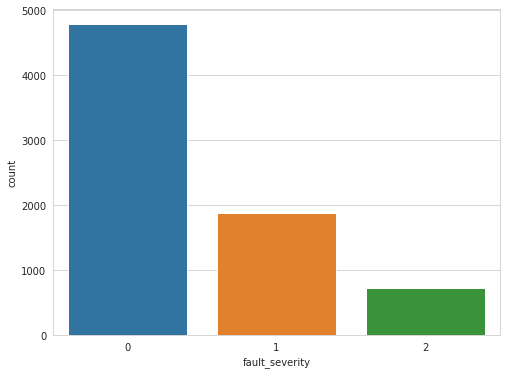

In [9]:
plt.figure(figsize = (8,6))
sns.countplot(train_4['fault_severity'])
plt.show()

Not very balanced data set as values with fault_severity ‘zero’ (indicating no fault) are very high as compared with others. So ML models might be biased towards fault severity value of ‘zero’.

**Count plot for severity type**

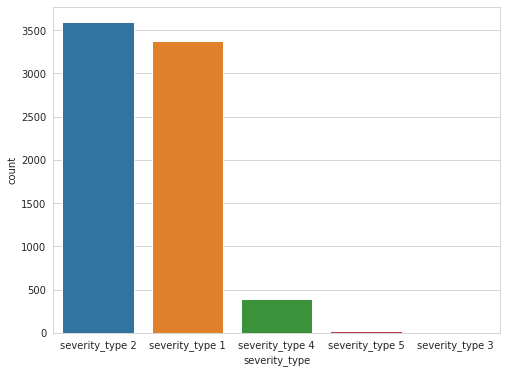

In [10]:
plt.figure(figsize = (8,6))
sns.countplot(train_4['severity_type'])
plt.show()

Severity_type_1 and 2 are very high as compared with others.

**Count plot for resource type**

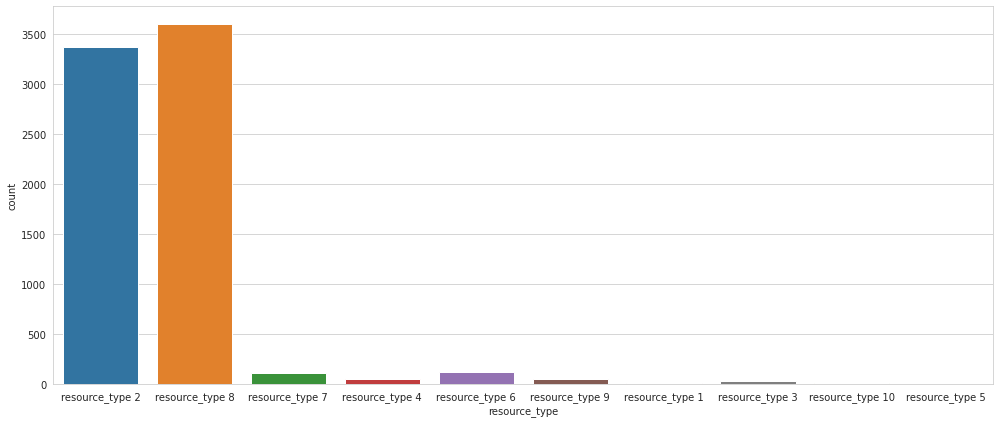

In [11]:
plt.figure(figsize = (14,6))
sns.countplot(train_4['resource_type'])
plt.tight_layout()
plt.show()

Most of the resource types are either type_2 or type_8.

# CatBoost

Catboost is an opensource machine learning algorithm from Yandex (Russian search engine like Google). It can work with wide range of data types and can help solve various problems. The catboost algo does not need extensive training (computing efficiency)  and can better handle categorical features.

In [12]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [13]:
X = train_4[['id', 'location', 'severity_type', 'resource_type',
       'log_feature', 'volume', 'event_type']]
y = train_4.fault_severity

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=101)

In [15]:
categorical_features_indices = np.where(X_train.dtypes == object)[0]

In [16]:
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=categorical_features_indices)

eval_dataset = Pool(data=X_validation,
                    label=y_validation,
                    cat_features=categorical_features_indices)

In [17]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',
                           random_seed=1,
                           bagging_temperature=22,
                           od_type='Iter',
                           metric_period=100,
                           od_wait=100)

In [18]:
model.fit(train_dataset, eval_set= eval_dataset, plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8097318	test: 0.8037832	best: 0.8037832 (0)	total: 58.1ms	remaining: 58s
100:	learn: 0.6558387	test: 0.6635586	best: 0.6635003 (98)	total: 581ms	remaining: 5.17s
200:	learn: 0.6334645	test: 0.6597332	best: 0.6573367 (180)	total: 1.09s	remaining: 4.33s
300:	learn: 0.6185366	test: 0.6560338	best: 0.6524754 (227)	total: 1.59s	remaining: 3.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6524753949
bestIteration = 227

Shrink model to first 228 iterations.


**As the model was getting overfit  after initial iterations so it was stopped by overfitting detector in Catboost.**

In [19]:
# Get predicted classes
preds_class = model.predict(eval_dataset)

# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)

# Getting the test set ready to feed into the model

In [20]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [21]:
test_1 = test.merge(severity_type, how = 'left', left_on='id', right_on='id')
test_2 = test_1.merge(resource_type, how = 'left', left_on='id', right_on='id')
test_3 = test_2.merge(log_failure, how = 'left', left_on='id', right_on='id')
test_4 = test_3.merge(event_type, how = 'left', left_on='id', right_on='id')

In [22]:
test_4.head()

,id,location,severity_type,resource_type,log_feature,volume,event_type
0,11066,location 481,severity_type 2,resource_type 2,feature 230,24,event_type 35
1,11066,location 481,severity_type 2,resource_type 2,feature 230,24,event_type 34
2,11066,location 481,severity_type 2,resource_type 2,feature 310,28,event_type 35
3,11066,location 481,severity_type 2,resource_type 2,feature 310,28,event_type 34
4,11066,location 481,severity_type 2,resource_type 2,feature 228,20,event_type 35


**Remove duplicate values**

In [23]:
test_4.drop_duplicates(subset= 'id', keep= 'first', inplace = True)
test_4.head()

,id,location,severity_type,resource_type,log_feature,volume,event_type
0,11066,location 481,severity_type 2,resource_type 2,feature 230,24,event_type 35
8,18000,location 962,severity_type 1,resource_type 8,feature 203,9,event_type 11
12,16964,location 491,severity_type 2,resource_type 2,feature 235,10,event_type 35
16,4795,location 532,severity_type 5,resource_type 3,feature 240,1,event_type 27
28,3392,location 600,severity_type 2,resource_type 8,feature 82,6,event_type 15


In [24]:
test_4.isnull().sum()

id               0
location         0
severity_type    0
resource_type    0
log_feature      0
volume           0
event_type       0
dtype: int64

# Making predictions on test set

In [25]:
predict_test=model.predict_proba(test_4)
pred_df=pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
submission_cat=pd.concat([test[['id']],pred_df],axis=1)
submission_cat.to_csv('sub_cat_1.csv',index=False,header=True)

In [26]:
submission_cat.head()

,id,predict_0,predict_1,predict_2
0,11066,0.988431,0.011280,0.000289
1,18000,0.309371,0.127360,0.563269
2,16964,0.986726,0.013234,0.000039
3,4795,0.520250,0.447789,0.031961
4,3392,0.365517,0.334049,0.300434


**These are the predicted probabilites. The column with the highest value is the predicted class of severity.**